In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [17]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) > 0.8

## Train LightFM

In [19]:
train_data = positives[~positives["test"]]
test_data = positives[positives["test"]]

In [20]:
dataset = ld.Dataset()
dataset.fit(positives["user"], positives["track"])

In [21]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [22]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2022-03-06 18:59:31,027] A new study created in memory with name: no-name-8e8c3d26-e7c5-4545-8309-26e98f7ab784
[I 2022-03-06 18:59:31,135] Trial 0 finished with value: 0.0 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.01}. Best is trial 0 with value: 0.0.
[I 2022-03-06 18:59:31,226] Trial 1 finished with value: 0.0005649717641063035 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.001}. Best is trial 1 with value: 0.0005649717641063035.
[I 2022-03-06 18:59:31,285] Trial 2 finished with value: 0.0007532956660725176 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.001, 'item_alpha': 0.01}. Best is trial 2 with value: 0.0007532956660725176.
[I 2022-03-06 18:59:31,374] Trial 3 finished with value: 0.0001883239165181294 and parameters: {'loss': 'bpr', 'no_compon

In [24]:
best_params

{'loss': 'bpr',
 'no_components': 10,
 'learning_rate': 0.001,
 'max_sampled': 10,
 'user_alpha': 0.001,
 'item_alpha': 0.01}

In [25]:
model, precisions_at = fit_model(
    epochs=30,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.0003766478330362588 +/- 0.0005215145631288094
1:	0.0003766478330362588 +/- 0.0005215145631288094
2:	0.0003766478330362588 +/- 0.0005215145631288094
3:	0.0003766478330362588 +/- 0.0005215145631288094
4:	0.0003766478330362588 +/- 0.0005215145631288094
5:	0.0003766478330362588 +/- 0.0005215145631288094
6:	0.0003766478330362588 +/- 0.0005215145631288094
7:	0.0001883239165181294 +/- 0.00036911486771098296
8:	0.0001883239165181294 +/- 0.00036911486771098296
9:	0.0001883239165181294 +/- 0.00036911486771098296
10:	0.0001883239165181294 +/- 0.00036911486771098296
11:	0.0 +/- 0.0
12:	0.0001883239165181294 +/- 0.00036911486771098296
13:	0.0001883239165181294 +/- 0.00036911486771098296
14:	0.0001883239165181294 +/- 0.00036911486771098296
15:	0.0001883239165181294 +/- 0.00036911486771098296
16:	0.0 +/- 0.0
17:	0.0 +/- 0.0
18:	0.0 +/- 0.0
19:	0.0 +/- 0.0
20:	0.0 +/- 0.0
21:	0.0 +/- 0.0
22:	0.0 +/- 0.0
23:	0.0 +/- 0.0
24:	0.0 +/- 0.0
25:	0.0 +/- 0.0
26:	0.0 +/- 0.0
27:	0.0 +/- 0.0
28:	0.0 +/- 0.

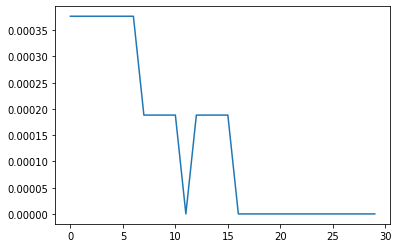

In [26]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [27]:
biases, embeddings = model.get_item_representations()

In [31]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [32]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [33]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [34]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [35]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": users[user_index],
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1823/1823 [00:00<00:00, 2228.46it/s]
